<h1>Notebook to plot some general clustering information</h1>

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os
import sys
basedir = '/Users/joewandy/git/metabolomics_tools'
sys.path.append(basedir)

In [10]:
import numpy as np
import pylab as plt
import pandas as pd
from scipy.stats import ttest_rel

import seaborn as sns
sns.set(color_codes=True)
from IPython.display import display, HTML

import cPickle
import random
import copy
import glob
import gzip
import string

In [11]:
from alignment.models import HyperPars as AlignmentHyperPars
from alignment.experiment import *
from efcompute.ef_assigner import ef_assigner

In [12]:
input_dir = '/Users/joewandy/git/metabolomics_tools/alignment/input/std1_csv_full_old'
transformation_file = '/Users/joewandy/git/metabolomics_tools/alignment/pos_transformations_full.yml'
gt_file = '/Users/joewandy/git/metabolomics_tools/alignment/input/std1_csv_full_old/ground_truth/ground_truth.txt'

In [13]:
hp = AlignmentHyperPars()    
hp.within_file_mass_tol = 5
hp.within_file_rt_tol = 30
hp.across_file_mass_tol = 10
hp.across_file_rt_tol = 60
hp.alpha_mass = 1.0
hp.dp_alpha = 1000.0
hp.beta = 0.1
hp.t = 0.0
hp.mass_clustering_n_iterations = 5000
hp.rt_clustering_nsamps = 500
hp.rt_clustering_burnin = 0

print hp

Hyperparameters across_file_mass_tol=10, across_file_rt_tol=60, alpha_mass=1.0, beta=0.1, dp_alpha=1000.0, mass_clustering_n_iterations=5000, matching_alpha=0.3, rt_clustering_burnin=0, rt_clustering_nsamps=500, second_stage_clustering_use_adduct_likelihood=True, second_stage_clustering_use_mass_likelihood=True, second_stage_clustering_use_rt_likelihood=True, t=0.0, within_file_mass_tol=5, within_file_rt_tol=30


<h1>1. Load the data</h1>

In [14]:
# combined_list = load_or_create_clustering('pickles/std1_pos_clustering.p', input_dir, transformation_file, hp)
# print "Loaded %s" % [x[0].filename for x in combined_list]

In [15]:
# selected_files = [x[0] for x in combined_list]  
# selected_clusterings = [x[1] for x in combined_list]            
# aligner = Aligner(selected_files, None, transformation_file, hp, verbose=False, seed=1234567890)
# match_mode = 1
# aligner.run(match_mode, first_stage_clustering_results=selected_clusterings)

In [19]:
clustering_out = 'pickles/cm_all_standards.p'

In [20]:
# with gzip.GzipFile(clustering_out, 'wb') as f:
#     cPickle.dump(aligner, f, protocol=cPickle.HIGHEST_PROTOCOL)                    
# print "Saved clustering to %s" % clustering_out

In [21]:
aligner = load_clustering(clustering_out)

Loaded from pickles/cm_all_standards.p


<h1>2. Plot some general statistics</h1>

In [40]:
def plot_cluster_size(acs, exclude_singleton=False):
    size_rows = []
    singleton_rows = []
    for f in range(len(acs)):
        ac = acs[f]
        singleton_count = 0
        non_singleton_count = 0
        for cluster in ac.clusters:
            n_member = len(cluster.members)
            if exclude_singleton and n_member == 1:
                singleton_count += 1
                continue
            if n_member == 0:
                continue
            filename = 'Standard File %02d' % (f+1)
            size_rows.append((filename, cluster.id, len(cluster.members)))
            non_singleton_count += 1
        singleton_rows.append((filename, singleton_count, non_singleton_count))
    df = pd.DataFrame(size_rows, columns=['std_file', 'cluster', 'cluster_size'])
    fig = plt.figure(figsize=(12, 6))    
    sns.countplot(x='cluster_size', hue='std_file', data=df.sort_values(by=['cluster_size', 'std_file']))
    fig.get_axes()[0].legend(loc='upper right')    
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_facecolor('white')    
    plt.tight_layout()
    plt.title('Cluster size in all standard files', fontsize=36)
    plt.savefig('figures/counts_cluster.pdf')

    df = pd.DataFrame(singleton_rows, columns=['std_file', 'singleton', 'non-singleton'])
    display(df)

In [50]:
def plot_trans(acs, exclude_MH=True, size=4, aspect=1):
    rows = []
    mh_count = 0
    non_mh_count = 0
    for f in range(len(acs)):
        ac = acs[f]
        for cluster in ac.clusters:
            for peak, poss in cluster.members:
                fn = 'Standard File %02d' % peak.file_id
                if 'M+H' not in poss.transformation.name:
                    mh_count += 1
                else:
                    non_mh_count += 1
                if not exclude_MH:
                    rows.append((cluster.id, peak.feature_id, fn, peak.mass, peak.rt, peak.intensity,
                                 poss.transformation.name, poss.transformed_mass, poss.prob))
                elif 'M+H' not in poss.transformation.name:
                    rows.append((cluster.id, peak.feature_id, fn, peak.mass, peak.rt, peak.intensity,
                                 poss.transformation.name, poss.transformed_mass, poss.prob))
                
    df = pd.DataFrame(rows, columns=["clusterID", "peakID", "std_file", "mass", "RT", "intensity", "transition", "trans_mass", "prob"])  

    # plot trans counts
    plt.figure()
    sns.factorplot(y='transition', hue='std_file', data=df.sort_values(by=['transition', 'std_file']), kind='count', 
                   size=size, aspect=aspect, legend=False)
    plt.title('Transition types in all standard files', fontsize=36)
    plt.tight_layout()
    plt.savefig('figures/counts_trans.pdf')
    
    # plot trans probabilities
#     if exclude_MH:    
#         plt.figure()
#         sns.factorplot(y="transition", x="prob", hue="std_file", data=df.sort_values(by=['transition', 'std_file']), kind='box', size=size, aspect=aspect)

    # print the counts
    print "Total peaks having M+H trans = %d" % mh_count
    print "Total peaks having non-M+H trans = %d" % non_mh_count

In [51]:
def plot_biggest(clustering_results, threshold, file_idx):

    ac = clustering_results[file_idx]
    clusters_list = ac.clusters
    singleton_count = 0

    big_clusters = []
    biggest = clusters_list[0]
    for cluster in clusters_list:
        if cluster.N == 1:
            singleton_count += 1
        if cluster.N >= threshold:
            big_clusters.append(cluster)
            if cluster.N >= biggest.N:
                biggest = cluster

    print "Singleton count {}".format(singleton_count)
    print "{} big clusters found".format(len(big_clusters))
    print "Biggest has {} members".format(biggest.N)
    file_idx += 1

    for c in big_clusters:
        ac.cluster_plot(c)

In [52]:
data_list = aligner.data_list
hp = aligner.hp
total_peaks = 0
for f in range(len(data_list)):
    data = data_list[f]
    count = len(data.features)
    print "%d peaks in file %d" % (count, f)
    total_peaks += count
print "total peaks %d" % total_peaks

4999 peaks in file 0
4986 peaks in file 1
6836 peaks in file 2
9752 peaks in file 3
7076 peaks in file 4
4146 peaks in file 5
6319 peaks in file 6
4101 peaks in file 7
5485 peaks in file 8
5034 peaks in file 9
5317 peaks in file 10
total peaks 64051


,std_file,singleton,non-singleton
0,Standard File 01,4327,301
1,Standard File 02,4341,288
2,Standard File 03,5755,481
3,Standard File 04,8011,775
4,Standard File 05,5810,551
5,Standard File 06,3655,216
6,Standard File 07,5272,469
7,Standard File 08,3579,232
8,Standard File 09,4789,312
9,Standard File 10,4304,310


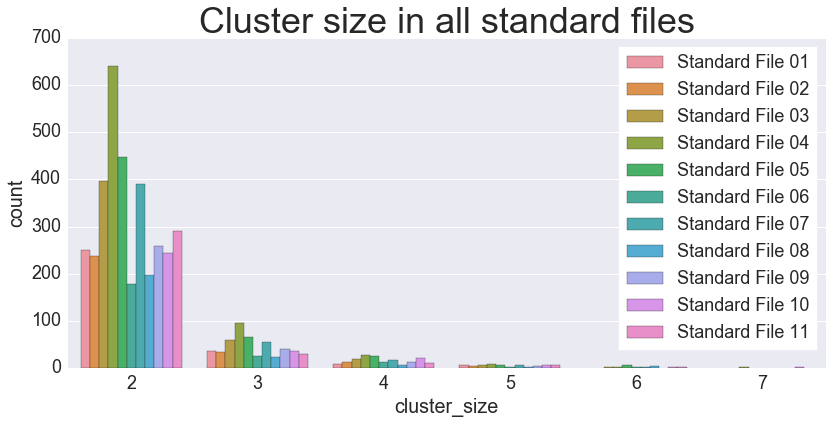

In [53]:
sns.set_context("notebook", font_scale=1.8)
plot_cluster_size(aligner.clustering_results, exclude_singleton=True)

Total peaks having M+H trans = 5015
Total peaks having non-M+H trans = 59036


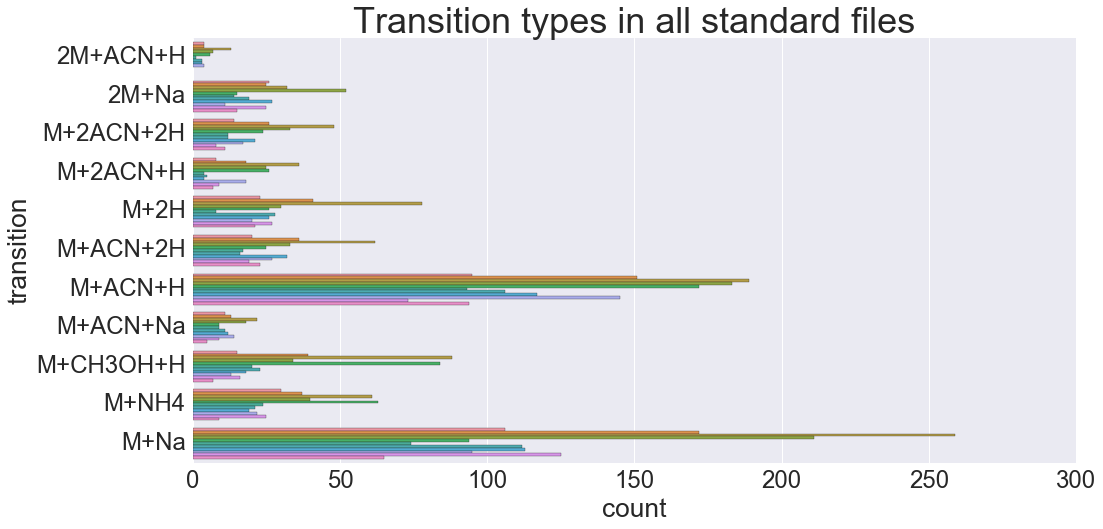

In [55]:
sns.set_context("notebook", font_scale=2.4)
plot_trans(aligner.clustering_results, exclude_MH=True, size=8, aspect=2)

In [272]:
# threshold = 6
# for f in range(len(data_list)):
#     plot_biggest(aligner.clustering_results, 6, f)